In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

train_dir = os.path.join(path, 'chest_xray/train')
test_dir = os.path.join(path, 'chest_xray/test')
val_dir = os.path.join(path, 'chest_xray/val')

100%|██████████| 2.29G/2.29G [00:23<00:00, 103MB/s]

Extracting files...


In [ ]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
try:
    for data_batch, labels_batch in validation_generator:
        print('Data batch shape:', data_batch.shape)
        print('Labels batch shape:', labels_batch.shape)
        break
except Exception as e:
    print("Error in validation generator:", e)


Data batch shape: (16, 150, 150, 3)
Labels batch shape: (16,)


In [ ]:
num_val_samples = sum([len(files) for r, d, files in os.walk(val_dir)])
validation_steps = num_val_samples // BATCH_SIZE

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=2,
    callbacks=[early_stopping]
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.7588 - loss: 0.5427 - val_accuracy: 0.6250 - val_loss: 0.9091
Epoch 2/2


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.9091


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step - accuracy: 0.8056 - loss: 0.4941
Test Accuracy: 0.79


In [ ]:
model.save('pneumonia_detection_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediction: Pneumonia Detected, Confidence: 0.68


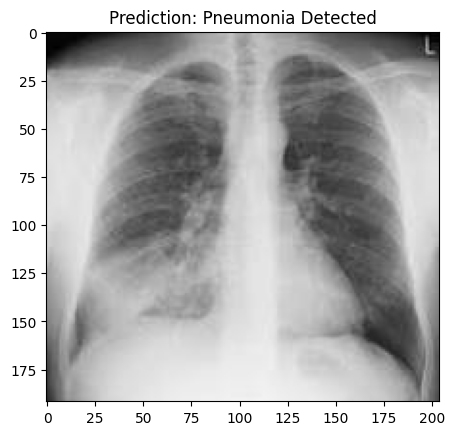

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model


model = load_model('pneumonia_detection_model.h5')


def preprocess_image(img_path, img_width=150, img_height=150):

    img = image.load_img(img_path, target_size=(img_width, img_height))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    return img_array

def predict_pneumonia(model, img_path):

    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)

    if prediction[0] > 0.5:
        return "Pneumonia Detected", prediction[0]
    else:
        return "Normal", prediction[0]

image_path = '/content/download.jpeg'
result, confidence = predict_pneumonia(model, image_path)

print(f"Prediction: {result}, Confidence: {confidence[0]:.2f}")

img = image.load_img(image_path)
plt.imshow(img)
plt.title(f"Prediction: {result}")
plt.show()
